In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

# command = """ foamDictionary $(foamListTimes -latestTime)/h -entry boundaryField.top -set "{type uniformInletOutlet; value $internalField; uniformInletValue {type csvFile; nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../experimental-data/headFixed_SW150/headFixed_1.csv\";} }" """

In [73]:
## Check CASES folder exists
cases_folder = Path("CASES")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [74]:
identifier = f"CASES/casetest"
of = OpenFOAM(
    path_case=identifier, write_to_log = True, path_template=template_folder
)


In [75]:
def set_boundary_csvFixedValue(self, csvfile):
    with open(csvfile) as f:
        _ = f.readline()
        first_value = f.readline().split(",")[1]

    ## Set fixedValue but reading from a CSV file
    self.set_value_in_foamDictionary(
        f"{self.latest_time}/h", 
        entry="boundaryField.top",
        value="""{type unsatTime; value """ + first_value + """; uniformValue csvFile; uniformValueCoeffs{nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../../""" + csvfile + """\";} }""")
        # value="""{type uniformFixedValue; value <internalField>; uniformValue tableFile; uniformValueCoeffs{file \"""" + csvfile + """\";} }""")

    # with open(self.path_case/Path(self.latest_time, "h")) as f:
    #     input = f.read()
    #     edited = input.replace("<internalField>", "$internalField")

    # with open(self.path_case/Path(self.latest_time, "h"), "w") as f:  
    #     f.write(edited)

## Make that function a bounded method of the OpenFOAM class
setattr(OpenFOAM, set_boundary_csvFixedValue.__name__, set_boundary_csvFixedValue)

In [76]:
of.set_boundary_csvFixedValue(f"experimental-data/headFixed_SW150/headFixed_1.csv")

In [77]:
cycle_times = [
    (41, 172),   #(time_to_dry, time_to_flood)
    (251, 411), 
    (461, 617), 
    (671, 822), 
    (881, 1033), 
    (1090, 1243),
    (1300, 1448),
    (1510, 1659), 
    (1721, 1866)
]

for i, cycle in enumerate(cycle_times, start=1):
    ## Cycle 1
    ## Dry: set fixedGradient 
    
    dryt, floodt = cycle

    of.logger(f"\n🔥 ======= Cycle {i}")
    of.logger("\n🔥 ======= Dry period ======")
    of.set_endtime(dryt)
    of.set_boundary_fixedGradient()
    of.set_convergeThreshold(0.12)
    of.cleanup_last_timestep()
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: 
        print(f"Died while drying in cycle {i}", status, of.latest_time)
        break
    
    # if input("Continue?") == "NO":
    #     break

    # Flood: use meadured head
    of.logger("\n🌊 ====== Flood period ======")
    of.set_endtime(floodt)
    # of.set_boundary_fixedValue(0.15)
    headFixed_time = f"experimental-data/headFixed_SW150/headFixed_{i}.csv"
    of.set_boundary_csvFixedValue(headFixed_time)
    of.set_convergeThreshold(0.001)
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: break

    if status != 0: 
        print(f"Died while flooding in cycle {i}", status, of.latest_time)
        break


#0  Foam::error::printStack(Foam::Ostream&) at ??:?
#1  Foam::sigFpe::sigHandler(int) at ??:?
#2  ? in "/lib/x86_64-linux-gnu/libc.so.6"
#3  Foam::FDICPreconditioner::FDICPreconditioner(Foam::lduMatrix::solver const&, Foam::dictionary const&) at ??:?
#4  Foam::lduMatrix::preconditioner::addsymMatrixConstructorToTable<Foam::FDICPreconditioner>::New(Foam::lduMatrix::solver const&, Foam::dictionary const&) at ??:?
#5  Foam::lduMatrix::preconditioner::New(Foam::lduMatrix::solver const&, Foam::dictionary const&) at ??:?
#6  Foam::PCG::solve(Foam::Field<double>&, Foam::Field<double> const&, unsigned char) const at ??:?
#7  Foam::fvMatrix<double>::solveSegregated(Foam::dictionary const&) at ??:?
#8  Foam::fvMatrix<double>::solve(Foam::dictionary const&) in "/home/edsaac/OpenFOAM/edsaac-7/platforms/linux64GccDPInt32Opt/bin/unsatNutrientCycle"
#9  Foam::fvMatrix<double>::solve() in "/home/edsaac/OpenFOAM/edsaac-7/platforms/linux64GccDPInt32Opt/bin/unsatNutrientCycle"
#10  ? in "/home/edsaac/Ope

Died while drying in cycle 2 -8 10320.000


In [78]:
print(of.latest_time, float(of.latest_time)/60, i)

10320.000 172.0 2


In [79]:
of.foam_to_vtk()
of.boundaryProbes_to_txt()

In [80]:
of.process_boundaryProbes()

In [88]:
of.boundaryProbes[0].probes_points

[probePoint(x=0.1, y=0.1, z=6.0), probePoint(x=0.1, y=0.1, z=0.0)]

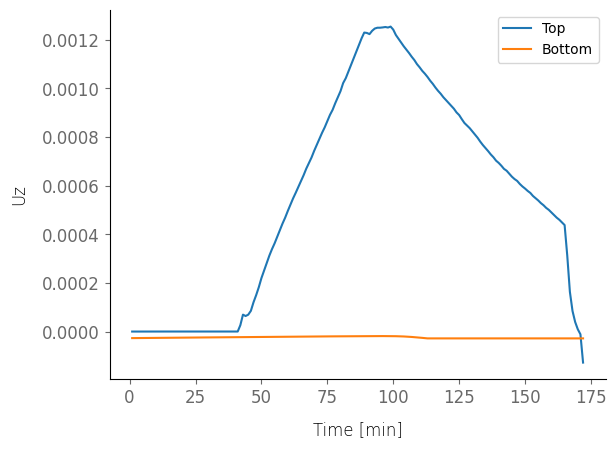

In [106]:
DIM = 1 # 0 for scalar, 1 for vector
FIELD = "Uz"

fig, ax = plt.subplots()
ax.plot(of.boundaryProbes[DIM].array_data.time/60, of.boundaryProbes[DIM].array_data[FIELD][0], label="Top")
ax.plot(of.boundaryProbes[DIM].array_data.time/60, of.boundaryProbes[DIM].array_data[FIELD][1], label="Bottom")
ax.legend()
ax.set_xlabel("Time [min]")
ax.set_ylabel(FIELD)
plt.show()

In [109]:
import json

field = "grad(h)"

with open("../Rosenzweig_2011/fit_ravid/heatmaps_config.json") as f:
    heatmaps_config = json.load(f)

default_pcolormesh_kwargs = dict(cmap="winter")
pcolormesh_kwargs = heatmaps_config.get(field) or default_pcolormesh_kwargs

of.plot_field_over_time(field, pcolormesh_kwargs)

ValueError: could not broadcast input array from shape (601,3) into shape (601,)